In [63]:
#import modules
import math
import numpy as np
from numpy.random import randint
from numpy import exp, pi
from numpy import linalg as LA
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=True)
import cv2
from PIL import Image
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import copy

#import files
import sys
sys.path.append('..')
from utils import matrix as mt
from utils import denoiser
from utils import message_passing as mp
from utils import PtychoEP
from utils import ptycho
from utils import test
from utils import config
from utils import engines
from utils import error

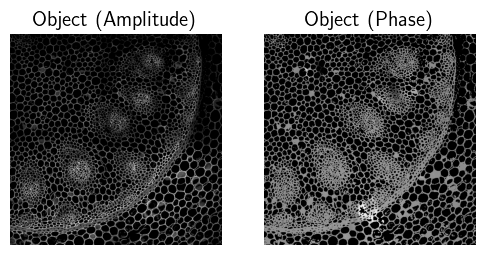

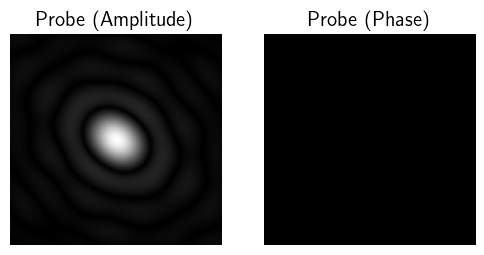

In [69]:
#load images (256 * 256 pixels)
path_obj_abs = "../data/lily.png"
path_obj_phase = "../data/moon.png"
obj = test.load_complex_image(path_obj_abs, path_obj_phase)

#load probe
probe_abs = np.array(Image.open("../data/probe.png"), dtype = "float")/256
prb = probe_abs + 1j * np.zeros_like(probe_abs)

#make round aperture (64 * 64 pixels)
aperture_x, aperture_y = np.meshgrid(np.linspace(-0.5, 0.5, num=64), np.linspace(-0.5, 0.5, num=64))
def Support(x, y):
    if x**2 + y**2 <= 0.5**2:
        return 1.
    else:
        return 0.
Pv = np.vectorize(Support)
aperture = Pv(aperture_x, aperture_y)
aperture = aperture + 1j * np.zeros_like(aperture) 

#showimages
test.show_complex_image(obj, "Object")
test.show_complex_image(prb, "Probe")

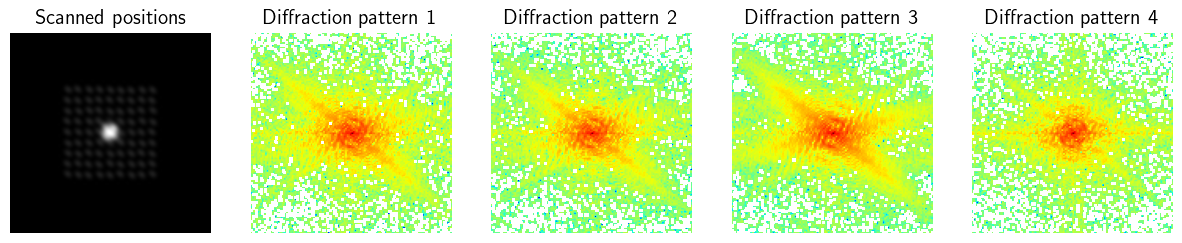

SNR =  35.541827691976366
Samping ratio =  250.48059584476675
Number of scans =  117


In [65]:
#set scan position and noise variance
noise = 0.00097
scan_positions = []

c = 6
for i in range(6):
    for j in range(6):
        scan_positions.append([240 + c * i + np.random.randint(-2,2), 240 + c * j + np.random.randint(-2,2)])

c = 27
for i in range(9):
    for j in range(9):
        scan_positions.append([147 + c * i + np.random.randint(-2,2), 147 + c * j + np.random.randint(-2,2)])

#sorting
scan_positions = np.array(scan_positions)
distance = []
for i, scan_pos in enumerate(scan_positions):
    distance.append((255 - scan_pos[0])**2 + (255 - scan_pos[1])**2)
distance = np.array(distance)
scan_positions = scan_positions[np.argsort(distance)]

#create Ptycho object 
ptycho_data = ptycho.Ptycho(obj, prb, scan_positions, noise)
ptycho_data.show()

#initial guess of probe
probe_guess_abs = np.array(Image.open("../data/probe_init.png"), dtype = "float")/256
prb_guess = probe_guess_abs + 1j * np.zeros_like(probe_guess_abs)

#show SNR, sampling ratio, and number of scans
total = 0
for diff in ptycho_data.diffs:
    total += np.mean(diff**2)
total /= len(scan_positions)
print("SNR = ",10 * np.log10(total/noise**2))
print("Samping ratio = ", ptycho_data.sampling_ratio)
print("Number of scans = ", len(ptycho_data.scan_pos))

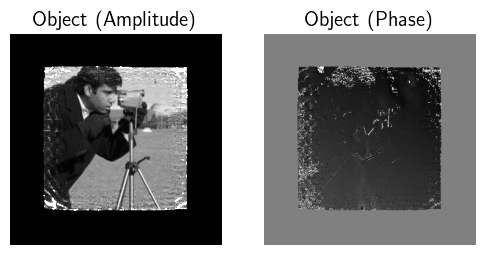

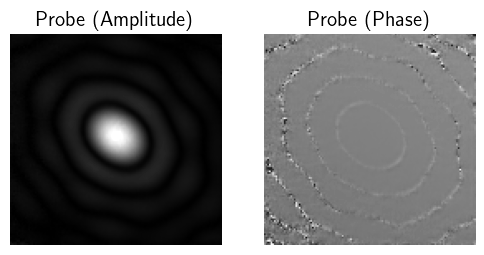

In [66]:
obj_init = mt.complex_gaussian_matrix(512, 1)
prb_init = copy.deepcopy(prb_guess)

#make config
num_iter = 200 #maximum iteration number
config_DM = config.config_DM(obj_init, prb_init, num_iter)

#run DM
obj_DM, prb_DM, error_DM = engines.DifferenceMap(ptycho_data, config_DM)

#show DM reconstruction
test.show_complex_image(obj_DM, "Object")
test.show_complex_image(prb_DM, "Probe")

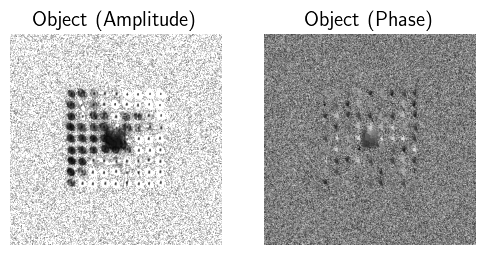

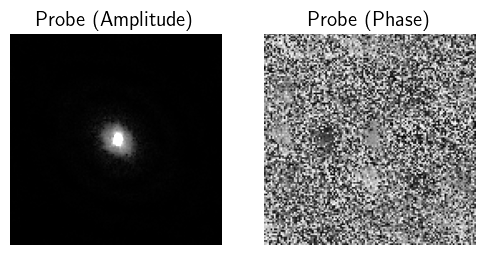

In [67]:
#load initial guess of probe
obj_init = mt.complex_gaussian_matrix(512, 1)
prb_init = copy.deepcopy(prb_guess)

#make config
alpha, beta = 1.0, 1.0 #step size parameters in ePIE
num_iter = 200 #maximum iteration number


#run ePIE
config_ePIE = config.config_ePIE(alpha, beta, obj_init, prb_init, num_iter)
obj_ePIE, prb_ePIE, error_ePIE = engines.ePIE(ptycho_data, config_ePIE)

#show ePIE reconstruction
test.show_complex_image(obj_ePIE, "Object")
test.show_complex_image(prb_ePIE, "Probe")

In [68]:
#load initial guess of probe
obj_init = mt.complex_gaussian_matrix(512, 1)
prb_init = copy.deepcopy(prb_guess)

num_iter = 100
num_prb = 2
damping = 0.9
rho = 0.4
config_PtychoEP_Sparse = config.config_PtychoEP_Sparse(obj_init, prb_init, num_iter, num_prb, damping, rho)

obj_PtychoEP_Sparse_EM, gamma_PtychoEP_Sparse_EM, prb_PtychoEP_Sparse_EM, error_PtychoEP_Sparse_EM = PtychoEP.PtychoEP_Sparse_EM(ptycho_data, config_PtychoEP_Sparse)

#show DM reconstruction
test.show_complex_image(obj_PtychoEP_Sparse_EM, "Object")
test.show_complex_image(prb_PtychoEP_Sparse_EM, "Probe")

KeyboardInterrupt: 

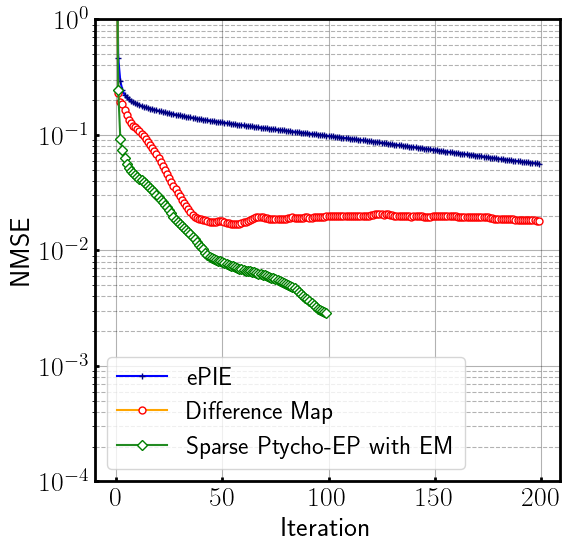

In [ ]:
#show result
fig, ax = plt.subplots(1,1, figsize=(6, 6))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error_ePIE/total, color = "blue", marker = "+", markeredgecolor = "navy", markerfacecolor = "white", markersize = 5, label = "ePIE")
ax.plot(error_DM/total, color = "orange", marker = "o", markeredgecolor = "red", markerfacecolor = "white", markersize = 5, label = "Difference Map")
#ax.plot(error_PtychoEP_Gaussian_EM/total, color = "magenta", marker = "D", markeredgecolor = "magenta", markerfacecolor = "white", markersize = 5, label = "Sparse Ptycho-EP with EM")
ax.plot(error_PtychoEP_Sparse_EM/total, color = "forestgreen", marker = "D", markeredgecolor = "green", markerfacecolor = "white", markersize = 5, label = "Sparse Ptycho-EP with EM")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_ylim(1e-4, 1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize = 18)
ax.grid(which='major',color='black',linestyle='-', alpha = 0.3)
ax.grid(which='minor',color='black',linestyle='--', alpha = 0.3)

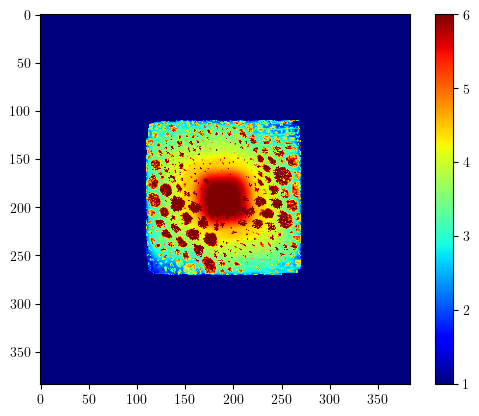

In [ ]:
plt.imshow(np.log10(gamma_PtychoEP_Sparse_EM[64:448, 64:448]), cmap = "jet", norm = Normalize(vmin = 1, vmax = 6))
plt.colorbar()

(-0.5, 446.5, 446.5, -0.5)

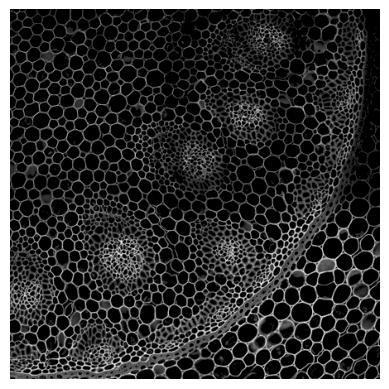

In [ ]:
plt.imshow(np.abs(obj[32:479, 32:479]), cmap = "gray", norm = Normalize(vmin = 0, vmax = 1))
plt.axis("off")

-2.878932507323935

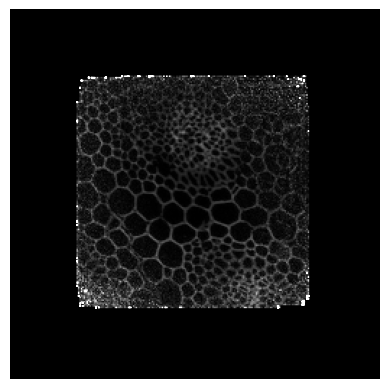

In [ ]:
plt.imshow(np.abs(obj_DM[128:384, 128:384]), cmap = "gray", norm = Normalize(vmin = 0, vmax = 1))
plt.axis("off")
-10*np.log10(error.error_metric_normalize(obj[128:384, 128:384], obj_DM[128:384, 128:384]))

-2.87450682917438

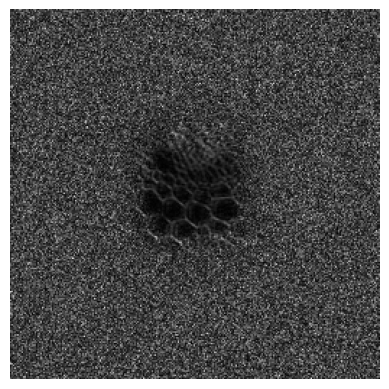

In [ ]:
plt.imshow(np.abs(obj_ePIE[128:384, 128:384]), cmap = "gray")
plt.axis("off")
-10*np.log10(error.error_metric_normalize(obj[128:384, 128:384], obj_ePIE[128:384, 128:384]))

-0.3523464870658636

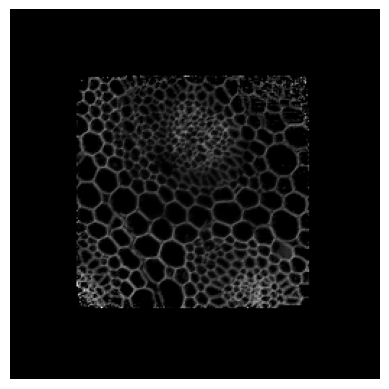

In [ ]:
plt.imshow(np.abs(obj_PtychoEP_Sparse_EM[128:384, 128:384]), cmap = "gray")
plt.axis("off")
-10*np.log10(error.error_metric_normalize(obj[128:384, 128:384], obj_PtychoEP_Sparse_EM[128:384, 128:384]))